In [1]:
# I intend to extend the project to 2D, and make it easier to change the potentials

# Boundary Conditions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import norm
from tqdm.auto import trange
from tqdm import tqdm

C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
# Setting Constants

#position boundaries
x_0 = 0
y_0 = 0
x_endpoints = np.linspace(-2, 2, 201)
y_endpoints = np.linspace(-2, 2, 201)

#time boundaries
t_i = 0
t_f = 8

#other constants
mass = 1
steps = 800
numb_paths = 1000

#array of times
times = np.linspace(t_i, t_f, steps)
dt = times[1] - times[0]
print(x_endpoints)

[-2.   -1.98 -1.96 -1.94 -1.92 -1.9  -1.88 -1.86 -1.84 -1.82 -1.8  -1.78
 -1.76 -1.74 -1.72 -1.7  -1.68 -1.66 -1.64 -1.62 -1.6  -1.58 -1.56 -1.54
 -1.52 -1.5  -1.48 -1.46 -1.44 -1.42 -1.4  -1.38 -1.36 -1.34 -1.32 -1.3
 -1.28 -1.26 -1.24 -1.22 -1.2  -1.18 -1.16 -1.14 -1.12 -1.1  -1.08 -1.06
 -1.04 -1.02 -1.   -0.98 -0.96 -0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0.82
 -0.8  -0.78 -0.76 -0.74 -0.72 -0.7  -0.68 -0.66 -0.64 -0.62 -0.6  -0.58
 -0.56 -0.54 -0.52 -0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34
 -0.32 -0.3  -0.28 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1
 -0.08 -0.06 -0.04 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14
  0.16  0.18  0.2   0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38
  0.4   0.42  0.44  0.46  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62
  0.64  0.66  0.68  0.7   0.72  0.74  0.76  0.78  0.8   0.82  0.84  0.86
  0.88  0.9   0.92  0.94  0.96  0.98  1.    1.02  1.04  1.06  1.08  1.1
  1.12  1.14  1.16  1.18  1.2   1.22  1.24  1.26  1.28

# Functions

In [41]:
#Creating the position generating function

def Pos_Gen(x0, xN, Steps, dt):
    path = np.zeros(Steps)
    path[0] = x0

    for i in range(1, Steps):
        path[i] = path[i-1] + np.random.normal(0, np.sqrt(dt))

    # shift so endpoint is exactly xN
    path += np.linspace(0, xN - path[-1], Steps)
    return path

In [42]:
#Creating function to evaluate the action integral for a path

def action_harmonic(positions, times, mass, potential):
    #Input Validation
    if type(positions) != np.ndarray:
        raise TypeError("WARNING: position input is not a numpy array")
    if type(times) != np.ndarray:
        raise TypeError("WARNING: time input is not a numpy array")

    #Calculating the action using discrete steps and straight line approx
    S = 0
    for i in range(len(times) - 1):
        dt = times[i + 1] - times[i]
        dx = positions[i + 1] - positions[i]
        T = 0.5 * mass * (dx / dt) ** 2

        x_mid = (positions[i] + positions[i+1])/2
        V = potential(x_mid)

        S += dt * (T + V)

    return S



In [43]:
# defining the x and y potentials

def x_potential(x):
    return 0.5 * x ** 2

def x_potential_eff(x, dt, m=1):
    return 0.5*x**2 + (dt**2 / (24*m)) * x**2

def y_potential(y):
    return 0.25*(y**2-1)**2
    # if np.abs(y) < 1:
    #     return 0
    # if np.abs(y) > 1:
    #     return 1e26



In [61]:
def metropolis_path_update_vectorised(paths, times, mass, potential, i, sigma_prop):
    """
    Vectorised Metropolis update for interior points of all paths.
    Includes kinetic + potential terms.

    paths: (n_paths, n_steps) array
    i: index of the interior point to update (1 <= i <= n_steps-2)
    sigma_prop: standard deviation of symmetric proposal distribution
    """
    dt = times[1] - times[0]

    x_old = paths[:, i]
    x_prev = paths[:, i - 1]
    x_next = paths[:, i + 1]

    # Symmetric Gaussian proposal
    x_new = x_old + np.random.normal(0, sigma_prop, size=x_old.shape)

    # Kinetic term change
    dS_kin = (mass / (2*dt)) * (
    (x_new - x_prev)**2 + (x_next - x_new)**2
  - (x_old - x_prev)**2 - (x_next - x_old)**2)



    # Potential term change
    x_mid_prev_old = 0.5 * (x_prev + x_old)
    x_mid_next_old = 0.5 * (x_old + x_next)
    x_mid_prev_new = 0.5 * (x_prev + x_new)
    x_mid_next_new = 0.5 * (x_new + x_next)
    dS_pot = dt * (
    potential(x_mid_prev_new) + potential(x_mid_next_new)
  - potential(x_mid_prev_old) - potential(x_mid_next_old)
    )


    # Total action change
    dS = dS_kin + dS_pot

    # Metropolis accept/reject
    accept = np.random.rand(len(x_old)) < np.exp(-dS)
    paths[accept, i] = x_new[accept]

    return np.mean(accept)  # return acceptance fraction for diagnostics

In [45]:
# def metropolis_endpoint_update_vectorised(paths, times, mass, potential, sigma_prop):
#     """
#     Vectorised Metropolis update for endpoint (last point) of all paths.
#     Uses a symmetric proposal around the previous point.
#     """
#     dt = times[1] - times[0]
#     i = paths.shape[1] - 1  # last point
#
#     x_old = paths[:, i]
#     x_prev = paths[:, i-1]
#
#     # symmetric proposal
#     x_new = x_old + np.random.normal(0, sigma_prop, size=x_old.shape)
#
#     # Kinetic term change (only one neighbor)
#     dS_kin = (mass / (2*dt)) * ((x_new - x_prev)**2 - (x_old - x_prev)**2)
#     dS_pot = dt * (potential(x_new) - potential(x_old))
#     dS = dS_kin + dS_pot
#
#     accept = np.random.rand(len(x_old)) < np.exp(-dS)
#     paths[accept, i] = x_new[accept]
#
#     return np.mean(accept)

In [46]:
# def metropolis_sweep_vectorised(paths, times, mass, potential, sigma_prop, sigma_endpoint):
#     n_steps = paths.shape[1]
#
#     # Store acceptance for diagnostics (interior)
#     acceptances = np.zeros(n_steps-2)
#
#     for i in range(1, n_steps-1):
#         acceptances[i-1] = metropolis_path_update_vectorised(paths, times, mass, potential, i, sigma_prop)
#
#     # Endpoint
#     endpoint_accept = metropolis_endpoint_update_vectorised(paths, times, mass, potential, sigma_endpoint)
#
#     return acceptances, endpoint_accept

def metropolis_sweep_vectorised(paths, times, mass, potential, sigma_prop):
    n_steps = paths.shape[1]

    acceptances = np.zeros(n_steps - 2)

    for i in range(1, n_steps - 1):
        acceptances[i - 1] = metropolis_path_update_vectorised(
            paths, times, mass, potential, i, sigma_prop
        )

    return acceptances



# X- Dimension

In [58]:
# Initialise paths (Brownian bridge)
paths_x = np.array([
    Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

C = 2.5

mid = paths_x.shape[1] // 2  # midpoint of the path
thin = 10                     # only record 1 sample every 'thin' sweeps
sigma_prop = C*np.sqrt(dt)          # proposal step, tune to get midpoint acceptance ~0.3-0.5
sigma_endpoint = sigma_prop/np.sqrt(2)

# -----------------------------
# Thermalisation
# -----------------------------
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances = metropolis_sweep_vectorised(
    paths_x, times, mass, x_potential, sigma_prop)

    midpoint_accept = acceptances[mid-1]

    # Optional: print every 100 sweeps
    if sweep % 100 == 0:
        tqdm.write(f"Midpoint acceptance ≈ {midpoint_accept:.3f}")

# -----------------------------
# Sampling
# -----------------------------
samples = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances = metropolis_sweep_vectorised(
    paths_x, times, mass, x_potential, sigma_prop)

    midpoint_accept = acceptances[mid-1]

    if k % 100 == 0:
        tqdm.write(f"Midpoint acceptance ≈ {midpoint_accept:.3f}")

    # Thinning: record sample every 'thin' sweeps
    if k % thin == 0:
        samples.append(paths_x[:, mid].copy())

samples = np.concatenate(samples)

# -----------------------------
# Measure ground-state PDF
# -----------------------------
# Extract equilibrated endpoints
endpoints = samples

x_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_x, bin_edges_x = np.histogram(endpoints, bins=x_bins)

x_centres = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])
dx = np.diff(x_bins)[0]

pdf_x = pdf_unnormalised_x / np.sum(pdf_unnormalised_x * dx)


# --- Analytic PDF for comparison ---
phi_sq_analytic = (1 / np.sqrt(np.pi)) * np.exp(-x_centres ** 2)
phi_sq_analytic /= np.sum(phi_sq_analytic * dx)  # normalize area to 1

print("------ Complete ------")

Thermalising:   1%|          | 4/500 [00:00<00:34, 14.47it/s]

Midpoint acceptance ≈ 0.305


Thermalising:  21%|██        | 104/500 [00:07<00:27, 14.61it/s]

Midpoint acceptance ≈ 0.342


Thermalising:  41%|████      | 204/500 [00:13<00:19, 14.86it/s]

Midpoint acceptance ≈ 0.321


Thermalising:  61%|██████    | 303/500 [00:20<00:13, 14.75it/s]

Midpoint acceptance ≈ 0.325


Thermalising:  81%|████████  | 404/500 [00:27<00:06, 14.64it/s]

Midpoint acceptance ≈ 0.307


Sampling:   0%|          | 4/5000 [00:00<05:37, 14.81it/s]

Midpoint acceptance ≈ 0.327


Sampling:   2%|▏         | 104/5000 [00:07<05:32, 14.74it/s]

Midpoint acceptance ≈ 0.330


Sampling:   4%|▍         | 203/5000 [00:13<05:32, 14.43it/s]

Midpoint acceptance ≈ 0.315


Sampling:   6%|▌         | 304/5000 [00:20<05:17, 14.78it/s]

Midpoint acceptance ≈ 0.327


Sampling:   8%|▊         | 404/5000 [00:27<05:12, 14.73it/s]

Midpoint acceptance ≈ 0.304


Sampling:  10%|█         | 504/5000 [00:34<05:06, 14.67it/s]

Midpoint acceptance ≈ 0.317


Sampling:  12%|█▏        | 603/5000 [00:41<04:58, 14.73it/s]

Midpoint acceptance ≈ 0.320


Sampling:  14%|█▍        | 703/5000 [00:47<04:57, 14.46it/s]

Midpoint acceptance ≈ 0.324


Sampling:  16%|█▌        | 803/5000 [00:54<04:48, 14.55it/s]

Midpoint acceptance ≈ 0.323


Sampling:  18%|█▊        | 904/5000 [01:01<04:40, 14.61it/s]

Midpoint acceptance ≈ 0.316


Sampling:  20%|██        | 1004/5000 [01:08<04:35, 14.51it/s]

Midpoint acceptance ≈ 0.331


Sampling:  22%|██▏       | 1104/5000 [01:15<04:24, 14.71it/s]

Midpoint acceptance ≈ 0.324


Sampling:  24%|██▍       | 1204/5000 [01:21<04:17, 14.74it/s]

Midpoint acceptance ≈ 0.314


Sampling:  26%|██▌       | 1303/5000 [01:28<04:17, 14.37it/s]

Midpoint acceptance ≈ 0.294


Sampling:  28%|██▊       | 1404/5000 [01:35<04:05, 14.62it/s]

Midpoint acceptance ≈ 0.320


Sampling:  30%|███       | 1504/5000 [01:42<03:57, 14.72it/s]

Midpoint acceptance ≈ 0.323


Sampling:  32%|███▏      | 1603/5000 [01:49<03:54, 14.46it/s]

Midpoint acceptance ≈ 0.313


Sampling:  34%|███▍      | 1704/5000 [01:56<03:44, 14.70it/s]

Midpoint acceptance ≈ 0.328


Sampling:  36%|███▌      | 1804/5000 [02:02<03:36, 14.76it/s]

Midpoint acceptance ≈ 0.351


Sampling:  38%|███▊      | 1903/5000 [02:09<03:33, 14.50it/s]

Midpoint acceptance ≈ 0.346


Sampling:  40%|████      | 2003/5000 [02:16<03:24, 14.69it/s]

Midpoint acceptance ≈ 0.316


Sampling:  42%|████▏     | 2104/5000 [02:23<03:16, 14.73it/s]

Midpoint acceptance ≈ 0.351


Sampling:  44%|████▍     | 2204/5000 [02:30<03:10, 14.67it/s]

Midpoint acceptance ≈ 0.320


Sampling:  46%|████▌     | 2304/5000 [02:36<03:01, 14.82it/s]

Midpoint acceptance ≈ 0.326


Sampling:  48%|████▊     | 2404/5000 [02:43<02:56, 14.70it/s]

Midpoint acceptance ≈ 0.329


Sampling:  50%|█████     | 2503/5000 [02:50<02:48, 14.80it/s]

Midpoint acceptance ≈ 0.336


Sampling:  52%|█████▏    | 2604/5000 [02:57<02:41, 14.82it/s]

Midpoint acceptance ≈ 0.334


Sampling:  54%|█████▍    | 2704/5000 [03:04<02:38, 14.52it/s]

Midpoint acceptance ≈ 0.339


Sampling:  56%|█████▌    | 2804/5000 [03:10<02:28, 14.80it/s]

Midpoint acceptance ≈ 0.342


Sampling:  58%|█████▊    | 2904/5000 [03:17<02:21, 14.79it/s]

Midpoint acceptance ≈ 0.340


Sampling:  60%|██████    | 3004/5000 [03:24<02:17, 14.54it/s]

Midpoint acceptance ≈ 0.326


Sampling:  62%|██████▏   | 3104/5000 [03:31<02:08, 14.72it/s]

Midpoint acceptance ≈ 0.307


Sampling:  64%|██████▍   | 3204/5000 [03:37<02:02, 14.70it/s]

Midpoint acceptance ≈ 0.308


Sampling:  66%|██████▌   | 3304/5000 [03:44<01:56, 14.53it/s]

Midpoint acceptance ≈ 0.326


Sampling:  68%|██████▊   | 3404/5000 [03:51<01:48, 14.66it/s]

Midpoint acceptance ≈ 0.329


Sampling:  70%|███████   | 3504/5000 [03:58<01:41, 14.73it/s]

Midpoint acceptance ≈ 0.321


Sampling:  72%|███████▏  | 3604/5000 [04:05<01:35, 14.58it/s]

Midpoint acceptance ≈ 0.343


Sampling:  74%|███████▍  | 3704/5000 [04:11<01:27, 14.74it/s]

Midpoint acceptance ≈ 0.306


Sampling:  76%|███████▌  | 3804/5000 [04:18<01:21, 14.76it/s]

Midpoint acceptance ≈ 0.307


Sampling:  78%|███████▊  | 3904/5000 [04:25<01:13, 14.82it/s]

Midpoint acceptance ≈ 0.332


Sampling:  80%|████████  | 4004/5000 [04:32<01:07, 14.79it/s]

Midpoint acceptance ≈ 0.343


Sampling:  82%|████████▏ | 4104/5000 [04:39<01:00, 14.77it/s]

Midpoint acceptance ≈ 0.306


Sampling:  84%|████████▍ | 4204/5000 [04:45<00:53, 14.82it/s]

Midpoint acceptance ≈ 0.328


Sampling:  86%|████████▌ | 4304/5000 [04:52<00:47, 14.52it/s]

Midpoint acceptance ≈ 0.351


Sampling:  88%|████████▊ | 4404/5000 [04:59<00:40, 14.76it/s]

Midpoint acceptance ≈ 0.312


Sampling:  90%|█████████ | 4504/5000 [05:06<00:33, 14.80it/s]

Midpoint acceptance ≈ 0.315


Sampling:  92%|█████████▏| 4603/5000 [05:12<00:27, 14.39it/s]

Midpoint acceptance ≈ 0.315


Sampling:  94%|█████████▍| 4704/5000 [05:19<00:19, 14.85it/s]

Midpoint acceptance ≈ 0.303


Sampling:  96%|█████████▌| 4804/5000 [05:26<00:13, 14.83it/s]

Midpoint acceptance ≈ 0.332


Sampling:  98%|█████████▊| 4903/5000 [05:33<00:06, 14.59it/s]

Midpoint acceptance ≈ 0.334


Sampling: 100%|██████████| 5000/5000 [05:39<00:00, 14.71it/s]

------ Complete ------


Numerical PDF area: 1.00000
Analytic PDF area: 1.00000


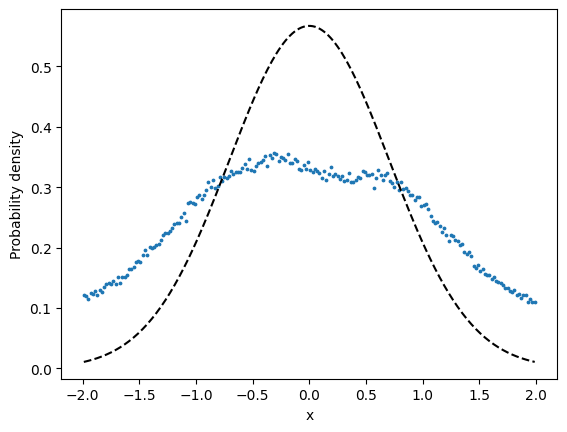

In [59]:
# --- Check areas ---
print(f"Numerical PDF area: {np.sum(pdf_x * dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic * dx):.5f}")
save_path = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\Summative_Wavefunction"

plt.figure(1)
plt.scatter(x_centres, pdf_x, label='Path integral estimate', s=3)
plt.plot(x_centres, phi_sq_analytic, 'k--', label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.savefig(save_path, bbox_inches='tight', format='svg')
plt.show()

In [60]:
mean_square = np.mean(samples**2)
rms = np.sqrt(mean_square)
std = np.std(samples)

print(f"Standard deviation is: {std}")
print(f"The root mean square is: {rms}")

Standard deviation is: 1.2843372469341838
The root mean square is: 1.2845069976643098


# Y- Dimension

In [93]:
#repeating for y
paths_y = []
weights_y = []
y_end = []

for yN in y_endpoints:
    for _ in range(numb_paths):
        p = Pos_Gen(y_0, yN, steps)
        S = action_harmonic(p, times, mass, y_potential)
        w = np.exp(-S)
        paths_y.append(p)
        weights_y.append(w)
        y_end.append(yN)

paths_y = np.array(paths_y)
weights_y = np.array(weights_y)
y_end = np.array(y_end)

print(paths_y[0])
print(len(paths_y))
print(paths_y[1001])
# Finding the groundstate wave function of the path
y_bins = np.linspace(-2, 2, 201)

pdf_unnormalised_y, bin_edges_y = np.histogram(y_end, bins=y_bins, weights=weights_y)
y_centres = 0.5 * (bin_edges_y[1:] + bin_edges_y[:-1])
dy = np.diff(y_bins)[0]

# normalize to integrate to 0.5 (since we only use x > 0)
area_y = np.sum(pdf_unnormalised_y * dy)
pdf_y = pdf_unnormalised_y / (area_y)

vary = np.linspace(-2, 2, 200)
omega = np.sqrt(2)  # harmonic approximation near minima
# Gaussian around each well
psi_left = (omega/np.pi)**0.25 * np.exp(-0.5*omega*(vary+1)**2)
psi_right = (omega/np.pi)**0.25 * np.exp(-0.5*omega*(vary-1)**2)
# Symmetric ground state
psi0 = (psi_left + psi_right)/np.sqrt(2)
pdf_vary = np.abs(psi0)**2
pdf_vary /= np.trapezoid(pdf_vary, vary)  # normalize

[ 0.          0.01647269 -0.12993828 -0.20990811 -0.15354225 -0.18058414
 -0.29400399 -0.26998897 -0.39065231 -0.37160055 -0.42903268 -0.53336888
 -0.49377994 -0.44734136 -0.45329064 -0.54576797 -0.60902314 -0.73458941
 -0.78410499 -0.69797048 -0.77428235 -1.01347767 -0.93601693 -0.9680082
 -0.96582206 -1.03127701 -0.97724296 -1.04962953 -1.12873815 -1.19104508
 -1.15061037 -1.22626112 -1.37566518 -1.45218432 -1.3874695  -1.41198218
 -1.48061106 -1.53979909 -1.56118232 -1.58037837 -1.65498504 -1.63570571
 -1.72904717 -1.70537562 -1.86401447 -1.85323198 -1.86260879 -1.86810341
 -1.9439954  -2.        ]
201000
[ 0.         -0.14930157  0.05072953 -0.17498992 -0.19278886 -0.22383827
 -0.23907844 -0.26633559 -0.2399319  -0.32419757 -0.40332402 -0.41872094
 -0.48703162 -0.49253766 -0.56170548 -0.59107251 -0.69018443 -0.62607152
 -0.72616458 -0.78410275 -0.79253149 -0.83925868 -0.91305824 -1.00471544
 -0.97904029 -0.98626866 -0.99233573 -1.22199442 -1.12466485 -1.11309926
 -1.0565167  -1.291

Numerical PDF area: 1.00000
Analytic PDF area: 1.00000


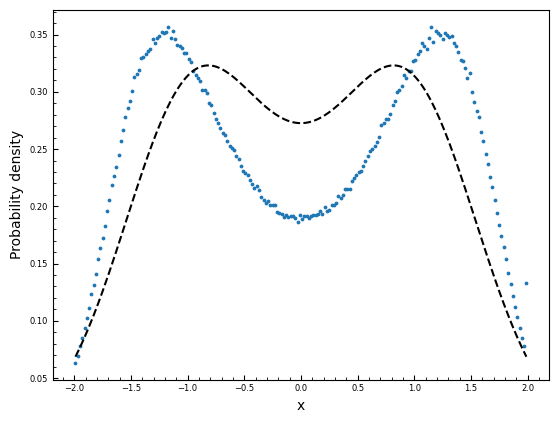

In [94]:
# --- Check areas ---
print(f"Numerical PDF area: {np.sum(pdf_y * dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic * dx):.5f}")
save_path = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\Summative_Wavefunction.svg"

plt.figure(1)
plt.scatter(y_centres, pdf_y, label='Path integral estimate', s=3)
plt.plot(y_centres, pdf_vary, 'k--', label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x')
plt.ylabel('Probability density')

plt.minorticks_on()
plt.tick_params(axis='both', which='major', direction='in')
plt.tick_params(axis='both', which='minor', direction='in')
plt.tick_params(which='major', labelsize=6)
plt.tick_params(which='minor', labelsize=3)

plt.savefig(save_path, bbox_inches='tight', format='svg')
plt.show()

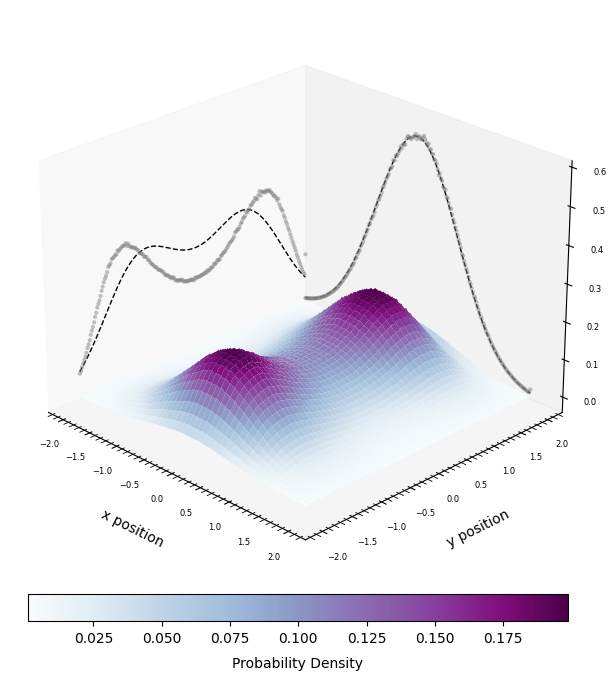

In [95]:
X,Y = np.meshgrid(x_centres, y_centres)

PDF = np.outer(pdf_y, pdf_x)

#normalise and renormalise from 1D to 2D

PDF = PDF / np.sum(PDF * dx * dy)

save_path_3d = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\wavefunction_3D.svg"

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')
fig.subplots_adjust(left=0)  # leave extra space

surf = ax.plot_surface(-X, Y, PDF, cmap='BuPu', antialiased=True, linewidth=0)


cbar = fig.colorbar(surf, ax=ax, shrink=0.7, pad=0.02, orientation = 'horizontal')
cbar.ax.set_position([0.1, 0.2, 0.7, 0.03])  # ([L,B,W,H])
cbar.set_label("Probability Density", labelpad=8)


ax.set_xlabel("x position", labelpad=10)
ax.set_ylabel("y position", labelpad=10)

ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r"$|\psi(x,y)|^2$", labelpad=12, rotation=0)

ax.view_init(elev=25, azim = -45)

ax.grid(False)

ax.minorticks_on()
ax.tick_params(axis = 'both',which = 'major', direction = 'in')
ax.tick_params(axis = 'both',which = 'minor', direction = 'in')
ax.tick_params(which = 'major', labelsize = 6)
ax.tick_params(which = 'minor', labelsize = 3)

# --- X-PDF projection onto the back Y-wall ---
Y_wall = np.full_like(x_centres, np.max(y_centres))
ax.scatter(x_centres, Y_wall, pdf_x, color="grey", linewidth=2, label="x-PDF projection", s = 1, alpha = 0.5)
ax.plot(x_centres, Y_wall, phi_sq_analytic, color="black", linewidth=1, label="x-PDF projection", linestyle = "--")

# --- Y-PDF projection onto the left X-wall ---
X_wall = np.full_like(y_centres, np.min(x_centres))
ax.scatter(X_wall, y_centres, pdf_y, color="grey", linewidth=2, label="y-PDF projection", s = 1, alpha = 0.5)
ax.plot(X_wall, y_centres, pdf_vary, color="black", linewidth=1, label="y-PDF projection", linestyle = "--")

plt.savefig(save_path_3d,bbox_inches = 'tight', format='svg')
plt.show()